<a href="https://colab.research.google.com/github/AryanMethil/Diabetes-KNN-vs-Naive-Bayes/blob/main/Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset Exploration



1.   Head of dataset
2.   Check for null values (absent)
3.   Check for class imbalance (present - remove it by upsampling)




In [2]:
# Read the csv file
import pandas as pd
df=pd.read_csv('/content/drive/My Drive/Diabetes/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Print the null values of every column
df.isna().sum()


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [4]:
# Print class count to check for imbalance
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [5]:
from sklearn.utils import resample
df_majority = df[df.Outcome==0]
df_minority = df[df.Outcome==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=500,    # to match majority class
                                 random_state=42) # reproducible results
 
# Combine majority class with upsampled minority class
df = pd.concat([df_majority, df_minority_upsampled])

print(df['Outcome'].value_counts())

1    500
0    500
Name: Outcome, dtype: int64


# Stratified K Folds Cross Validation

In [6]:
# Add a "kfolds" column which will indicate the validation set number
df['kfolds']=-1

# Shuffle all the rows and then reset the index
df=df.sample(frac=1,random_state=42).reset_index(drop=True)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,kfolds
0,4,117,62,12,0,29.7,0.380,30,1,-1
1,7,187,68,39,304,37.7,0.254,41,1,-1
2,8,105,100,36,0,43.3,0.239,45,1,-1
3,10,108,66,0,0,32.4,0.272,42,1,-1
4,0,132,78,0,0,32.4,0.393,21,0,-1


In [7]:
from sklearn import model_selection

# Create 5 sets of training,validation sets
strat_kf=model_selection.StratifiedKFold(n_splits=5)

# .split() returns a list of 5 lists (corresponding to the n_splits value)
# Each of these 5 lists consists of 2 lists. 1st one contains training set indices and 2nd one contains validation set indices
# In a dataset of 10 data points, data 1 and 2 will be the validation in 1st fold, data 3 and 4 in the second fold and so on
# 1st iteration of the for loop : trn_ = 3,4,5,6,7,8,9,10 and val_ = 1,2 and fold : 0
# Assign 1st and 2nd row's kfolds value as 0 representing that they will be the validation points for 1st (0th) fold

for fold,(trn_,val_) in enumerate(strat_kf.split(X=df,y=df['Outcome'])):
  df.loc[val_,'kfolds']=fold
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,kfolds
0,4,117,62,12,0,29.7,0.380,30,1,0
1,7,187,68,39,304,37.7,0.254,41,1,0
2,8,105,100,36,0,43.3,0.239,45,1,0
3,10,108,66,0,0,32.4,0.272,42,1,0
4,0,132,78,0,0,32.4,0.393,21,0,0


# Scale the features using StandardScaler

In [8]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
df_2=pd.DataFrame(scaler.fit_transform(df),index=df.index,columns=df.columns)

# Target column and kfolds column dont need to be scaled
df_2['Outcome']=df['Outcome']
df_2['kfolds']=df['kfolds']
df_2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,kfolds
0,-0.053578,-0.230248,-0.423269,-0.553283,-0.706292,-0.363725,-0.295300,-0.367793,1,0
1,0.787960,2.011697,-0.111124,1.128429,1.840594,0.691889,-0.680386,0.579018,1,0
2,1.068473,-0.614581,1.553653,0.941572,-0.706292,1.430819,-0.726229,0.923314,1,0
3,1.629498,-0.518498,-0.215172,-1.300711,-0.706292,-0.007455,-0.625373,0.665092,1,0
4,-1.175629,0.250169,0.409119,-1.300711,-0.706292,-0.007455,-0.255569,-1.142458,0,0


# Feature Selection

1.   KNN
2.   Naive Bayes

In [9]:
from sklearn import metrics
import matplotlib.pyplot as plt

In [10]:
def run(fold,df,models,print_details=False):
  
  # Training and validation sets
  df_train=df[df['kfolds']!=fold].reset_index(drop=True)
  df_valid=df[df['kfolds']==fold].reset_index(drop=True)


  # x and y of training dataset
  x_train=df_train.drop('Outcome',axis=1).values
  y_train=df_train.Outcome.values

  # x and y of validation dataset
  x_valid=df_valid.drop('Outcome',axis=1).values
  y_valid=df_valid.Outcome.values

  # accuracy => will store accuracies of the models  (same for confusion_matrices)
  accuracy=[]
  confusion_matrices=[]
  classification_report=[]

  for model_name,model_constructor in list(models.items()):
    clf=model_constructor
    clf.fit(x_train,y_train)

    # preds_train, preds_valid => predictions when training and validation x are fed into the trained model
    preds_train=clf.predict(x_train)
    preds_valid=clf.predict(x_valid)

    acc_train=metrics.accuracy_score(y_train,preds_train)
    acc_valid=metrics.accuracy_score(y_valid,preds_valid)
    conf_matrix=metrics.confusion_matrix(y_valid,preds_valid)
    class_report=metrics.classification_report(y_valid,preds_valid)

    accuracy.append(acc_valid)
    confusion_matrices.append(conf_matrix)
    classification_report.append(class_report)

    if(print_details==True):
      print(f'Model => {model_name} => Fold = {fold} => Training Accuracy = {acc_train} => Validation Accuracy = {acc_valid}')

  if(print_details==True):
    print('\n--------------------------------------------------------------------------------------------\n')
    
  return accuracy,confusion_matrices,classification_report

#### Greedy Feature Selection

In [11]:
def greedy_feature_selection(fold,df,models,target_name):

  # target_index => stores the index of the target variable in the dataset
  # kfolds_index => stores the index of kfolds column in the dataset
  target_index=df.columns.get_loc(target_name)
  kfolds_index=df.columns.get_loc('kfolds')

  # good_features => stores the indices of all the optimal features
  # best_scores => keeps track of the best scores 
  good_features=[]
  best_scores=[]

  # df has X and y and a kfolds column. 
  # no of features (no of columns in X) => total columns in df - 1 (there's 1 y) - 1 (there's 1 kfolds)
  num_features=df.shape[1]-2


  while True:

    # this_feature => the feature added to the already selected features to measure the effect of the former on the model
    # best_score => keeps track of the best score achieved while selecting features 1 at a time and checking its effect on the model
    this_feature=None
    best_score=0


    for feature in range(num_features):

      # if the feature is already in the good_features list, ignore and move ahead
      if feature in good_features:
        continue
      
      # add the currently selected feature to the already discovered good features
      selected_features=good_features+[feature]

      # all the selected features + target and kfolds column
      df_train=df.iloc[:, selected_features + [target_index,kfolds_index]]

      # fit the selected dataset to a model 
      accuracy,confusion_matrices,classification_report=run(fold,df_train,models)

      # if any improvement is observed over the previous set of features
      if(accuracy[0]>best_score):
        this_feature=feature
        best_score=accuracy[0]
      
    if(this_feature!=None):
      good_features.append(this_feature)
      best_scores.append(best_score)
    
    if(len(best_scores)>2):
      if(best_scores[-1]<best_scores[-2]):
        break
    
  return best_scores[:-1] , df.iloc[:, good_features[:-1] + [target_index,kfolds_index]]

      


#### Recursive Feature Selection

In [12]:
from sklearn.feature_selection import RFE

def recursive_feature_selection(df,models,n_features_to_select,target_name):
  X=df.drop(labels=[target_name,'kfolds'],axis=1).values
  y=df[target_name]
  kfolds=df.kfolds.values

  model_name,model_constructor=list(models.items())[0]

  rfe=RFE(
      estimator=model_constructor,
      n_features_to_select=n_features_to_select
  )

  try:
    rfe.fit(X,y)
  except RuntimeError:
    print(f"{model_name} does not support feature importance... Returning original dataframe\n")
    return df
  else:
    X_transformed = rfe.transform(X)
    df_optimal=pd.DataFrame(data=[X,y,kfolds])
    return df_optimal

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

In [29]:
print('Greedy Feature Selection : ')
print('\n')
models={'KNN': KNeighborsClassifier()}
best_scores,df_optimal_KNN=greedy_feature_selection(fold=4,df=df_2,models=models,target_name='Outcome')
print(df_optimal_KNN.head())

print('\n')
print("Recursive Feature Selection : ")
print('\n')
df_recursive_optimal_KNN=recursive_feature_selection(df=df_2,models=models,n_features_to_select=5,target_name='Outcome')
print(df_recursive_optimal_KNN.head())

Greedy Feature Selection : 


    Glucose  DiabetesPedigreeFunction       Age  Outcome  kfolds
0 -0.230248                 -0.295300 -0.367793        1       0
1  2.011697                 -0.680386  0.579018        1       0
2 -0.614581                 -0.726229  0.923314        1       0
3 -0.518498                 -0.625373  0.665092        1       0
4  0.250169                 -0.255569 -1.142458        0       0


Recursive Feature Selection : 


KNN does not support feature importance... Returning original dataframe

   Pregnancies   Glucose  BloodPressure  ...       Age  Outcome  kfolds
0    -0.053578 -0.230248      -0.423269  ... -0.367793        1       0
1     0.787960  2.011697      -0.111124  ...  0.579018        1       0
2     1.068473 -0.614581       1.553653  ...  0.923314        1       0
3     1.629498 -0.518498      -0.215172  ...  0.665092        1       0
4    -1.175629  0.250169       0.409119  ... -1.142458        0       0

[5 rows x 10 columns]


In [15]:
models={'Naive Bayes' : GaussianNB()}
best_scores,df_optimal_NB=greedy_feature_selection(fold=4,df=df_2,models=models,target_name='Outcome')
print(df_optimal_NB.head())

print('\n')
df_recursive_optimal_NB=recursive_feature_selection(df=df_2,models=models,n_features_to_select=5,target_name='Outcome')
print(df_recursive_optimal_NB.head())

    Glucose  Pregnancies       BMI  Outcome  kfolds
0 -0.230248    -0.053578 -0.363725        1       0
1  2.011697     0.787960  0.691889        1       0
2 -0.614581     1.068473  1.430819        1       0
3 -0.518498     1.629498 -0.007455        1       0
4  0.250169    -1.175629 -0.007455        0       0


Naive Bayes does not support feature importance... Returning original dataframe

   Pregnancies   Glucose  BloodPressure  ...       Age  Outcome  kfolds
0    -0.053578 -0.230248      -0.423269  ... -0.367793        1       0
1     0.787960  2.011697      -0.111124  ...  0.579018        1       0
2     1.068473 -0.614581       1.553653  ...  0.923314        1       0
3     1.629498 -0.518498      -0.215172  ...  0.665092        1       0
4    -1.175629  0.250169       0.409119  ... -1.142458        0       0

[5 rows x 10 columns]


# Hyperparameter Tuning in KNN

#### Manually finding the optimal value of n_neighbors parameter

In [16]:
# Find the optimal value of the n_neighbors parameter

models={f'KNN_{i}':KNeighborsClassifier(n_neighbors=i) for i in range(2,31)}

In [17]:
# run the model only for fold number 4 ie the 5th fold

accuracy,confusion_matrices,classification_report=run(fold=4,df=df_optimal_KNN,models=models,print_details=True)

Model => KNN_2 => Fold = 4 => Training Accuracy = 0.8825 => Validation Accuracy = 0.67
Model => KNN_3 => Fold = 4 => Training Accuracy = 0.85 => Validation Accuracy = 0.705
Model => KNN_4 => Fold = 4 => Training Accuracy = 0.8175 => Validation Accuracy = 0.725
Model => KNN_5 => Fold = 4 => Training Accuracy = 0.81625 => Validation Accuracy = 0.765
Model => KNN_6 => Fold = 4 => Training Accuracy = 0.8025 => Validation Accuracy = 0.705
Model => KNN_7 => Fold = 4 => Training Accuracy = 0.7975 => Validation Accuracy = 0.735
Model => KNN_8 => Fold = 4 => Training Accuracy = 0.79625 => Validation Accuracy = 0.71
Model => KNN_9 => Fold = 4 => Training Accuracy = 0.77375 => Validation Accuracy = 0.745
Model => KNN_10 => Fold = 4 => Training Accuracy = 0.785 => Validation Accuracy = 0.74
Model => KNN_11 => Fold = 4 => Training Accuracy = 0.77625 => Validation Accuracy = 0.72
Model => KNN_12 => Fold = 4 => Training Accuracy = 0.77875 => Validation Accuracy = 0.72
Model => KNN_13 => Fold = 4 => T

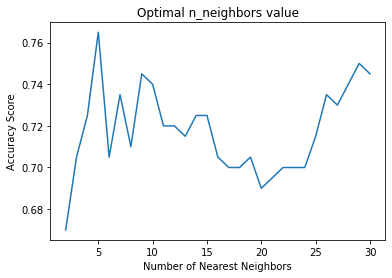

In [18]:
x=[i for i in range(2,31)]
y=accuracy
plt.plot(x,y)
plt.xlabel('Number of Nearest Neighbors')
plt.ylabel('Accuracy Score')
plt.title("Optimal n_neighbors value")
plt.show()

#### Using Grid Search to find optimal values of n_neighbors and p

In [20]:
from sklearn import model_selection
from sklearn import metrics

def hyperparameter_tune_and_run(df,num_folds,models,target_name,param_grid,evaluation_metric,print_details=False):
  X=df.drop(labels=[target_name,'kfolds'],axis=1).values
  y=df[target_name]

  model_name,model_constructor=list(models.items())[0]

  model = model_selection.GridSearchCV(
      estimator = model_constructor,
      param_grid = param_grid,
      scoring = evaluation_metric,
      verbose = 10,
      cv = num_folds
  )

  model.fit(X,y)

  if(print_details==True):
    print(f"Best score : {model.best_score_}")

    print("Best parameters : ")
    best_parameters=model.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
      print(f"\t{param_name}: {best_parameters[param_name]}")
  
  return model


In [21]:
models={'KNN': KNeighborsClassifier()}
param_grid = {
    "n_neighbors" : [i for i in range(2,31)],
    "p" : [2,3]
}
model = hyperparameter_tune_and_run(df=df_optimal_KNN,num_folds=5,models=models,target_name='Outcome',param_grid=param_grid,evaluation_metric="accuracy",print_details=True)

Fitting 5 folds for each of 58 candidates, totalling 290 fits
[CV] n_neighbors=2, p=2 ..............................................
[CV] .................. n_neighbors=2, p=2, score=0.770, total=   0.0s
[CV] n_neighbors=2, p=2 ..............................................
[CV] .................. n_neighbors=2, p=2, score=0.730, total=   0.0s
[CV] n_neighbors=2, p=2 ..............................................
[CV] .................. n_neighbors=2, p=2, score=0.785, total=   0.0s
[CV] n_neighbors=2, p=2 ..............................................
[CV] .................. n_neighbors=2, p=2, score=0.755, total=   0.0s
[CV] n_neighbors=2, p=2 ..............................................
[CV] .................. n_neighbors=2, p=2, score=0.740, total=   0.0s
[CV] n_neighbors=2, p=3 ..............................................
[CV] .................. n_neighbors=2, p=3, score=0.775, total=   0.0s
[CV] n_neighbors=2, p=3 ..............................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


[CV] .................. n_neighbors=3, p=3, score=0.765, total=   0.0s
[CV] n_neighbors=3, p=3 ..............................................
[CV] .................. n_neighbors=3, p=3, score=0.755, total=   0.0s
[CV] n_neighbors=3, p=3 ..............................................
[CV] .................. n_neighbors=3, p=3, score=0.775, total=   0.0s
[CV] n_neighbors=3, p=3 ..............................................
[CV] .................. n_neighbors=3, p=3, score=0.740, total=   0.0s
[CV] n_neighbors=4, p=2 ..............................................
[CV] .................. n_neighbors=4, p=2, score=0.755, total=   0.0s
[CV] n_neighbors=4, p=2 ..............................................
[CV] .................. n_neighbors=4, p=2, score=0.735, total=   0.0s
[CV] n_neighbors=4, p=2 ..............................................
[CV] .................. n_neighbors=4, p=2, score=0.720, total=   0.0s
[CV] n_neighbors=4, p=2 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done 290 out of 290 | elapsed:    4.3s finished


# Comparison between KNN and NB

1.   Dataset when KNN was considered for feature selection
2.   Dataset when NB was considered for feature selection



In [39]:
# Compare between KNN and Naive Bayes

models={
        'KNN': KNeighborsClassifier(n_neighbors=12,p=3),
        'Gaussian Naive Bayes': GaussianNB(),
        }

In [40]:
# accuracies => list of 5 lists. Each list will contain 3 values ie KNN accuracy, Gaussian Naive Bayes

accuracies,confusion_matrices,classification_reports=[],[],[]
for f in range(5):
  accuracy,confusion_matrix,classification_report=run(f,df_optimal_KNN,models=models,print_details=True)
  accuracies.append(accuracy)
  confusion_matrices.append(confusion_matrix)
  classification_reports.append(classification_report)

Model => KNN => Fold = 0 => Training Accuracy = 0.75 => Validation Accuracy = 0.75
Model => Gaussian Naive Bayes => Fold = 0 => Training Accuracy = 0.7125 => Validation Accuracy = 0.705

--------------------------------------------------------------------------------------------

Model => KNN => Fold = 1 => Training Accuracy = 0.74625 => Validation Accuracy = 0.755
Model => Gaussian Naive Bayes => Fold = 1 => Training Accuracy = 0.7125 => Validation Accuracy = 0.725

--------------------------------------------------------------------------------------------

Model => KNN => Fold = 2 => Training Accuracy = 0.74875 => Validation Accuracy = 0.75
Model => Gaussian Naive Bayes => Fold = 2 => Training Accuracy = 0.70875 => Validation Accuracy = 0.71

--------------------------------------------------------------------------------------------

Model => KNN => Fold = 3 => Training Accuracy = 0.7675 => Validation Accuracy = 0.755
Model => Gaussian Naive Bayes => Fold = 3 => Training Accuracy =

In [41]:
print(accuracies)

[[0.75, 0.705], [0.755, 0.725], [0.75, 0.71], [0.755, 0.7], [0.725, 0.715]]


In [42]:
x_axis_labels=['Predicted Normal','Predicted Diabetic']
y_axis_labels=['True Normal','True Diabetic']

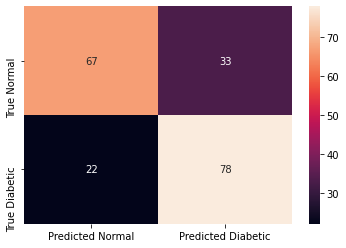

In [43]:
import seaborn as sns

# Heatmap of confusion matrix of 5th fold of KNN

sns.heatmap(confusion_matrices[4][0],xticklabels=x_axis_labels,yticklabels=y_axis_labels,annot=True)


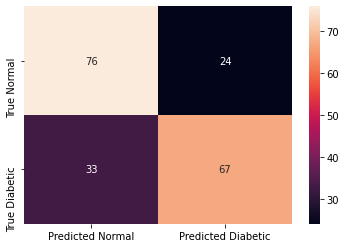

In [44]:
# Heatmap of confusion matrix of 5th fold of Naive Bayes

sns.heatmap(confusion_matrices[4][1],xticklabels=x_axis_labels,yticklabels=y_axis_labels,annot=True)


In [45]:
# Classification report of 5th fold of KNN

print("KNN")
print(classification_reports[4][0])

KNN
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       100
           1       0.70      0.78      0.74       100

    accuracy                           0.73       200
   macro avg       0.73      0.73      0.72       200
weighted avg       0.73      0.72      0.72       200



In [46]:
# Classification report of 5th fold of Naive Bayes

print("Naive Bayes")
print(classification_reports[4][1])

Naive Bayes
              precision    recall  f1-score   support

           0       0.70      0.76      0.73       100
           1       0.74      0.67      0.70       100

    accuracy                           0.71       200
   macro avg       0.72      0.72      0.71       200
weighted avg       0.72      0.71      0.71       200



In [47]:
accuracies,confusion_matrices,classification_reports=[],[],[]
for f in range(5):
  accuracy,confusion_matrix,classification_report=run(f,df_optimal_NB,models=models,print_details=True)
  accuracies.append(accuracy)
  confusion_matrices.append(confusion_matrix)
  classification_reports.append(classification_report)

Model => KNN => Fold = 0 => Training Accuracy = 0.77125 => Validation Accuracy = 0.7
Model => Gaussian Naive Bayes => Fold = 0 => Training Accuracy = 0.74 => Validation Accuracy = 0.715

--------------------------------------------------------------------------------------------

Model => KNN => Fold = 1 => Training Accuracy = 0.77 => Validation Accuracy = 0.74
Model => Gaussian Naive Bayes => Fold = 1 => Training Accuracy = 0.7325 => Validation Accuracy = 0.75

--------------------------------------------------------------------------------------------

Model => KNN => Fold = 2 => Training Accuracy = 0.7875 => Validation Accuracy = 0.73
Model => Gaussian Naive Bayes => Fold = 2 => Training Accuracy = 0.7275 => Validation Accuracy = 0.76

--------------------------------------------------------------------------------------------

Model => KNN => Fold = 3 => Training Accuracy = 0.7725 => Validation Accuracy = 0.705
Model => Gaussian Naive Bayes => Fold = 3 => Training Accuracy = 0.7462

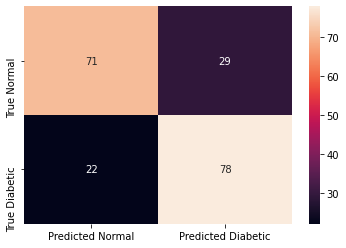

In [48]:
import seaborn as sns

# Heatmap of confusion matrix of 5th fold of KNN

sns.heatmap(confusion_matrices[4][0],xticklabels=x_axis_labels,yticklabels=y_axis_labels,annot=True)

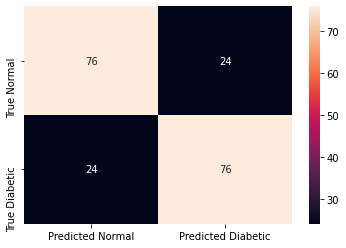

In [49]:
# Heatmap of confusion matrix of 5th fold of Naive Bayes

sns.heatmap(confusion_matrices[4][1],xticklabels=x_axis_labels,yticklabels=y_axis_labels,annot=True)

In [50]:
# Classification report of 5th fold of KNN

print("KNN")
print(classification_reports[4][0])

KNN
              precision    recall  f1-score   support

           0       0.76      0.71      0.74       100
           1       0.73      0.78      0.75       100

    accuracy                           0.74       200
   macro avg       0.75      0.74      0.74       200
weighted avg       0.75      0.74      0.74       200



In [51]:
# Classification report of 5th fold of Naive Bayes

print("Naive Bayes")
print(classification_reports[4][1])

Naive Bayes
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       100
           1       0.76      0.76      0.76       100

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.76      0.76      0.76       200

